## FIRST MODEL
DETECTING MELANOMAS BY COMPUTER VISION


prueba con dataset original desbalanceado


Importation of libraries

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing import image
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall

## LOADING AND PREPROCESSING


As we found in the preprocessing part, we have on hte training file:

Total benign images: 6705
Total malignant images: 1113

Where we can see that we have much less data in the malignant folder, so it is advisable to perform data augmentation to more efficiently achieve the balance between classes and thus better learn the characteristics of both classes.

We also add 1140 images from other dataset to balance data

In [4]:


# Definir directorios
base_dir = r"C:\Users\jakif\CODE\PROYECTO-FINAL\images\PREPROCESSED_DATA_copy"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directorios para cada clase

benign_dir = os.path.join(train_dir, 'benign_images')
malignant_dir = os.path.join(train_dir, 'malignant_images')


print(f"Total de imágenes benignas en el train: {len(os.listdir(benign_dir))}")
print(f"Total de imágenes malignas en el train: {len(os.listdir(malignant_dir))}")
print(f"Total de imágenes: ",len(os.listdir(benign_dir)) +len(os.listdir(malignant_dir)) )


Total de imágenes benignas en el train: 6705
Total de imágenes malignas en el train: 1113
Total de imágenes:  7818


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,       # Mayor rango de rotación
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,         # Incluir shear
    zoom_range=0.2,          # Zoom aleatorio
    horizontal_flip=True,
    vertical_flip=True,      # Añadir volteo vertical
    fill_mode='nearest'
)



train_generator = train_datagen.flow_from_directory(
    train_dir,  # Ahora contiene las imágenes aumentadas en malignant_combined
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Generador para test (sin cambios)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("Classes learned:", train_generator.class_indices)

Found 7818 images belonging to 2 classes.
Found 1079 images belonging to 2 classes.
Classes learned: {'benign_images': 0, 'malignant_images': 1}


We have achived a best balance between the two classes

In [6]:


# Construcción del modelo CNN

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),  # Capa adicional
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),         # Más neuronas
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compilación del modelo
# Usar Adam con un learning rate más bajo

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)
# Resumen del modelo
model.summary()


c:\Users\jakif\anaconda3\envs\COMPUTER_VISION\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,263,809 (73.49 MB)

 Trainable params: 19,263,809 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback


best_recall = -np.inf
best_loss = np.inf

def save_on_improvement(epoch, logs):
    global best_recall, best_loss
    
    current_recall = logs.get('val_recall')
    current_loss = logs.get('val_loss')
    
    if current_recall > best_recall and current_loss < best_loss:
        best_recall = current_recall
        best_loss = current_loss
        model.save(f'best_model_epoch_{epoch}.h5')  # Guarda el modelo
        print(f"¡Modelo guardado! (Recall: {best_recall:.4f}, Loss: {best_loss:.4f})")

callbacks = [
    EarlyStopping(monitor='val_recall', mode='max', patience=10),
    LambdaCallback(on_epoch_end=save_on_improvement)
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)


c:\Users\jakif\anaconda3\envs\COMPUTER_VISION\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.8467 - loss: 0.4121 - precision: 0.0000e+00 - recall: 0.0000e+00

¡Modelo guardado! (Recall: 0.0000, Loss: 0.3680)
245/245 ━━━━━━━━━━━━━━━━━━━━ 130s 523ms/step - accuracy: 0.8467 - loss: 0.4120 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8415 - val_loss: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8638 - loss: 0.3198 - precision: 0.3824 - recall: 0.0046

¡Modelo guardado! (Recall: 0.1462, Loss: 0.3383)
245/245 ━━━━━━━━━━━━━━━━━━━━ 156s 638ms/step - accuracy: 0.8637 - loss: 0.3198 - precision: 0.3829 - recall: 0.0047 - val_accuracy: 0.8397 - val_loss: 0.3383 - val_precision: 0.4808 - val_recall: 0.1462
Epoch 3/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 116s 472ms/step - accuracy: 0.8518 - loss: 0.3211 - precision: 0.4376 - recall: 0.0492 - val_accuracy: 0.8146 - val_loss: 0.3546 - val_precision: 0.4000 - val_recall: 0.3392
Epoch 4/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 117s 477ms/step - accuracy: 0.8601 - loss: 0.3118 - precision: 0.5114 - recall: 0.0943 - val_accuracy: 0.8415 - val_loss: 0.3790 - val_precision: 0.5000 - val_recall: 0.0585
Epoch 5/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8622 - loss: 0.3022 - precision: 0.5173 - recall: 0.0606

¡Modelo guardado! (Recall: 0.2690, Loss: 0.3261)
245/245 ━━━━━━━━━━━━━━━━━━━━ 119s 486ms/step - accuracy: 0.8622 - loss: 0.3022 - precision: 0.5173 - recall: 0.0607 - val_accuracy: 0.8452 - val_loss: 0.3261 - val_precision: 0.5227 - val_recall: 0.2690
Epoch 6/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 116s 474ms/step - accuracy: 0.8611 - loss: 0.3042 - precision: 0.5684 - recall: 0.1263 - val_accuracy: 0.8415 - val_loss: 0.3666 - val_precision: 0.5000 - val_recall: 0.2982
Epoch 7/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 115s 469ms/step - accuracy: 0.8635 - loss: 0.2934 - precision: 0.5242 - recall: 0.1179 - val_accuracy: 0.8387 - val_loss: 0.4338 - val_precision: 0.4211 - val_recall: 0.0468
Epoch 8/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.8634 - loss: 0.3042 - precision: 0.5668 - recall: 0.1679

¡Modelo guardado! (Recall: 0.3977, Loss: 0.3084)
245/245 ━━━━━━━━━━━━━━━━━━━━ 115s 468ms/step - accuracy: 0.8634 - loss: 0.3042 - precision: 0.5669 - recall: 0.1680 - val_accuracy: 0.8554 - val_loss: 0.3084 - val_precision: 0.5620 - val_recall: 0.3977
Epoch 9/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 117s 476ms/step - accuracy: 0.8629 - loss: 0.2869 - precision: 0.5328 - recall: 0.1972 - val_accuracy: 0.8647 - val_loss: 0.3075 - val_precision: 0.6712 - val_recall: 0.2865
Epoch 10/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 114s 467ms/step - accuracy: 0.8660 - loss: 0.2837 - precision: 0.6182 - recall: 0.2550 - val_accuracy: 0.8628 - val_loss: 0.3065 - val_precision: 0.6055 - val_recall: 0.3860
Epoch 11/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 115s 468ms/step - accuracy: 0.8749 - loss: 0.2761 - precision: 0.6409 - recall: 0.2671 - val_accuracy: 0.8703 - val_loss: 0.2993 - val_precision: 0.7541 - val_recall: 0.2690
Epoch 12/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8725 - loss: 0.2747 - precision: 0.

¡Modelo guardado! (Recall: 0.4795, Loss: 0.2890)
245/245 ━━━━━━━━━━━━━━━━━━━━ 116s 472ms/step - accuracy: 0.8725 - loss: 0.2747 - precision: 0.5978 - recall: 0.2743 - val_accuracy: 0.8693 - val_loss: 0.2890 - val_precision: 0.6119 - val_recall: 0.4795
Epoch 13/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 117s 476ms/step - accuracy: 0.8780 - loss: 0.2643 - precision: 0.6395 - recall: 0.3272 - val_accuracy: 0.8619 - val_loss: 0.3014 - val_precision: 0.5902 - val_recall: 0.4211
Epoch 14/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 116s 472ms/step - accuracy: 0.8828 - loss: 0.2645 - precision: 0.6865 - recall: 0.3025 - val_accuracy: 0.8795 - val_loss: 0.2745 - val_precision: 0.6783 - val_recall: 0.4561
Epoch 15/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 116s 474ms/step - accuracy: 0.8818 - loss: 0.2694 - precision: 0.6568 - recall: 0.3254 - val_accuracy: 0.8749 - val_loss: 0.2802 - val_precision: 0.6579 - val_recall: 0.4386
Epoch 16/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 117s 475ms/step - accuracy: 0.8840 - loss: 0.2605 - precision:

¡Modelo guardado! (Recall: 0.5497, Loss: 0.2743)
245/245 ━━━━━━━━━━━━━━━━━━━━ 196s 801ms/step - accuracy: 0.8809 - loss: 0.2679 - precision: 0.6699 - recall: 0.3394 - val_accuracy: 0.8740 - val_loss: 0.2743 - val_precision: 0.6144 - val_recall: 0.5497
Epoch 21/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 203s 805ms/step - accuracy: 0.8935 - loss: 0.2534 - precision: 0.7180 - recall: 0.4385 - val_accuracy: 0.8860 - val_loss: 0.2857 - val_precision: 0.7222 - val_recall: 0.4561
Epoch 22/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 2913s 12s/step - accuracy: 0.8934 - loss: 0.2559 - precision: 0.7160 - recall: 0.4332 - val_accuracy: 0.8842 - val_loss: 0.2745 - val_precision: 0.7447 - val_recall: 0.4094
Epoch 23/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.8961 - loss: 0.2435 - precision: 0.6987 - recall: 0.4284

¡Modelo guardado! (Recall: 0.6199, Loss: 0.2711)
245/245 ━━━━━━━━━━━━━━━━━━━━ 199s 810ms/step - accuracy: 0.8961 - loss: 0.2435 - precision: 0.6986 - recall: 0.4284 - val_accuracy: 0.8703 - val_loss: 0.2711 - val_precision: 0.5856 - val_recall: 0.6199
Epoch 24/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 196s 798ms/step - accuracy: 0.8949 - loss: 0.2491 - precision: 0.6896 - recall: 0.4478 - val_accuracy: 0.8777 - val_loss: 0.2832 - val_precision: 0.7191 - val_recall: 0.3743
Epoch 25/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 200s 816ms/step - accuracy: 0.8947 - loss: 0.2446 - precision: 0.7027 - recall: 0.4337 - val_accuracy: 0.8925 - val_loss: 0.2586 - val_precision: 0.7391 - val_recall: 0.4971
Epoch 26/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 197s 804ms/step - accuracy: 0.8950 - loss: 0.2369 - precision: 0.6852 - recall: 0.4065 - val_accuracy: 0.8730 - val_loss: 0.2819 - val_precision: 0.5895 - val_recall: 0.6550
Epoch 27/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 197s 803ms/step - accuracy: 0.8971 - loss: 0.2444 - precision:

34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 661ms/step - accuracy: 0.8805 - loss: 0.2527 - precision: 0.6352 - recall: 0.4655

    loss: 0.2523
    Accuracy: 88.23%
    Precision: 70.00%
    Recall: 45.03%



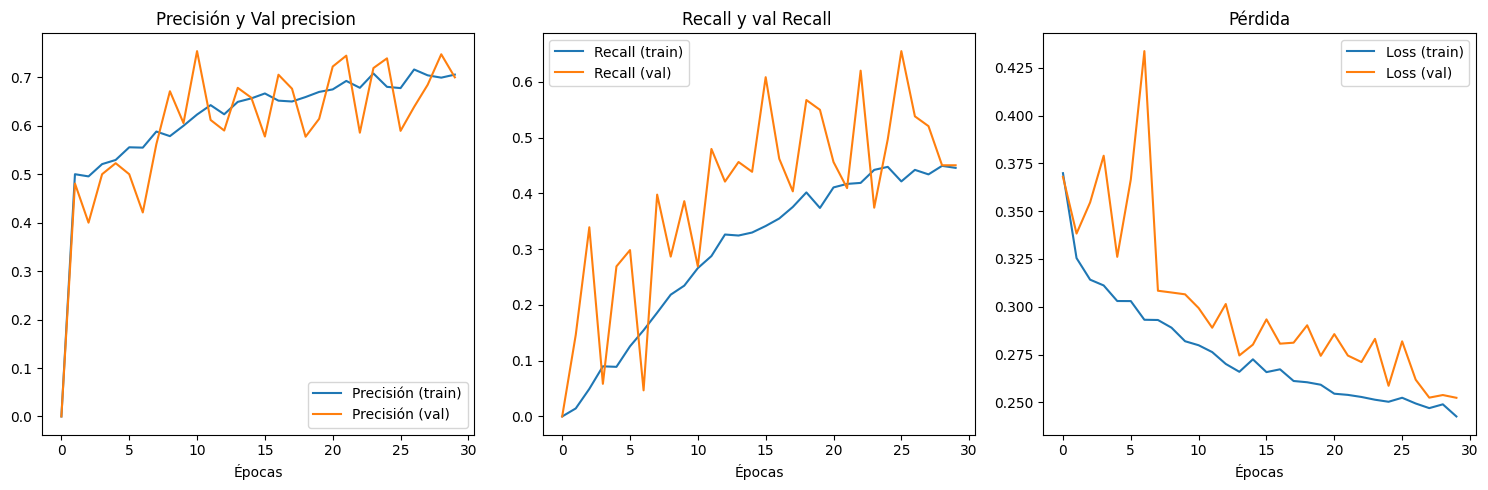

In [8]:
# Evaluar el modelo en el conjunto de prueba

results = model.evaluate(test_generator)  # Devuelve [loss, accuracy, precision, recall]
print(f'''
    loss: {results[0]:.4f}
    Accuracy: {results[1]*100:.2f}%
    Precision: {results[2]*100:.2f}%
    Recall: {results[3]*100:.2f}%
''')


# Graficar la precisión y la pérdida
plt.figure(figsize=(15, 5))

# Gráfico 1: Precisión y Recall de entrenamiento
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], label='Precisión (train)')
plt.plot(history.history['val_precision'], label='Precisión (val)')

plt.title('Precisión y Val precision ')
plt.xlabel('Épocas')
plt.legend()

# Gráfico 2: Precisión y Recall de validación
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Recall (train)')
plt.plot(history.history['val_recall'], label='Recall (val)')
plt.title('Recall y val Recall ')
plt.xlabel('Épocas')
plt.legend()

# Gráfico 3: Pérdida
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.legend()

plt.tight_layout()
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step
F1 Score: 0.08
                  precision    recall  f1-score   support

   benign_images       0.84      0.92      0.88       908
malignant_images       0.12      0.06      0.08       171

        accuracy                           0.78      1079
       macro avg       0.48      0.49      0.48      1079
    weighted avg       0.73      0.78      0.75      1079



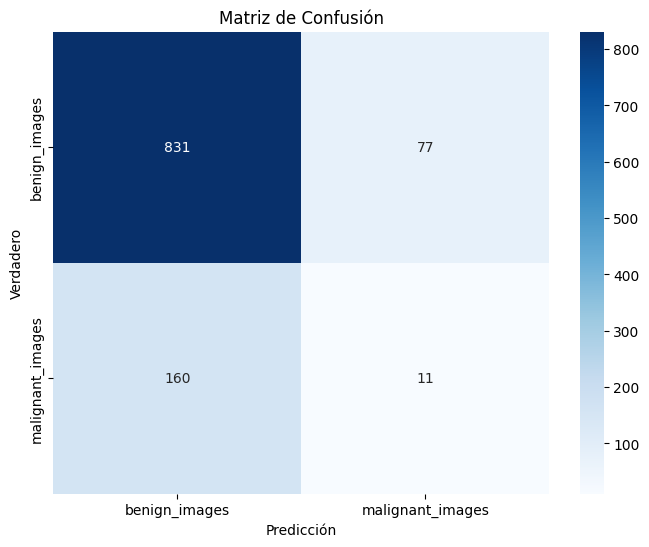

In [18]:
#Evaluar con F1 Score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener las predicciones del modelo y las etiquetas verdaderas
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).flatten()
# Calcular el F1 Score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.2f}')
# Imprimir el informe de clasificación
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicción')
plt.ylabel('Verdadero')

plt.title('Matriz de Confusión')
plt.show()

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
#importar modulo Image



In [11]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
        
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output#[0]
    #print(np.expand_dims(last_conv_layer_output,axis=0))
    #print(pooled_grads[..., tf.newaxis])
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [12]:
def display_gradcam(img, heatmap, cam_path, alpha=0.4,preds=[0,0], plot=None):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #importar imagen
    from IPython.display import Image
    
    cam_path= r"C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\test\malignant_images\ISIC_0034529.jpg"
    display(Image(cam_path))
    plt.figure(figsize=(8,8))
    plot.imshow(superimposed_img)
    plot.set(title ="Mel:{:.3f}\n Nev:{:.3f}\
      ".format(preds[0], preds[1]))
    plot.axis('off')
    plt.show()

In [13]:
def get_img_array(img):
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [14]:
test_image = next(iter(test_generator))[0][5]
# Prepare image
img_array =get_img_array(test_image)

# Load the model
model = tf.keras.models.load_model('best_model_epoch_4.h5')
last_conv_layer_name = 'conv2d_31'
# Get the last convolutional layer
last_conv_layer = model.get_layer(last_conv_layer_name)
# Get the model's predictions
preds = model.predict(img_array)
# Print the predicted class

# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)
# Generate class activation heatmap
heatmap = gradcam_heatmap(img_array, model, last_conv_layer_name)

heatmap = np.reshape(heatmap, (12,12))
# Display heatmap
plt.matshow(heatmap)

plt.show()

ValueError: No such layer: conv2d_31. Existing layers are: ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3', 'flatten', 'dense', 'dropout', 'dense_1'].